In [8]:
import numpy as np
import pandas as pd
import os
import glob
import bioframe
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import gzip
import warnings

In [9]:
L_TFs = ["GABPA", "PRDM5", "SP140", "ZNF362", "ZNF407"]
F_TFs = [_ for _ in os.listdir("/home/gregory.andrews-umw/IBIS/data/CHS/") if _ not in L_TFs]
TFs = L_TFs + F_TFs
assays = ["CHS", "GHTS"]
with open("IBIS-Metadata-Genomic.txt", "w") as f:
    for tf in TFs:
        peaks = glob.glob("/home/gregory.andrews-umw/IBIS/data/CHS/{}/*".format(tf))
        n = len(peaks)
        nPeaks = 0
        for p in peaks:
            nPeaks += pd.read_csv(p, sep="\t", skiprows=1, skipfooter=1, engine="python").shape[0]
        if tf in L_TFs:
            phase = "L"
        else:
            phase = "F"
        print(tf, "CHS", phase, n, nPeaks, sep="\t", file=f)
    
    for tf in TFs:
        if tf in L_TFs:
            phase = "L"
        else:
            phase = "F"
            
        for cycle in ["C1", "C2", "C3", "C4"]:
            peaks = [x for x in glob.glob("/home/gregory.andrews-umw/IBIS/data/GHTS/{}/*".format(tf)) if cycle in x]
            n = len(peaks)
            nPeaks = 0
            for p in peaks:
                nPeaks += pd.read_csv(p, sep="\t", skiprows=1, skipfooter=1, engine="python").shape[0]
            if n == 0:
                print(tf, "GHTS-{}".format(cycle), "absent", n, nPeaks, sep="\t", file=f)
            else:
                print(tf, "GHTS-{}".format(cycle), phase, n, nPeaks, sep="\t", file=f)

In [10]:
!cat IBIS-Metadata-Genomic.txt | head

GABPA	CHS	L	1	2287
PRDM5	CHS	L	2	51671
SP140	CHS	L	1	806
ZNF362	CHS	L	3	116599
ZNF407	CHS	L	1	1126
CAMTA1	CHS	F	1	1114
LEUTX	CHS	F	3	2397
MYF6	CHS	F	1	22639
PRDM13	CHS	F	1	6871
SALL3	CHS	F	1	545


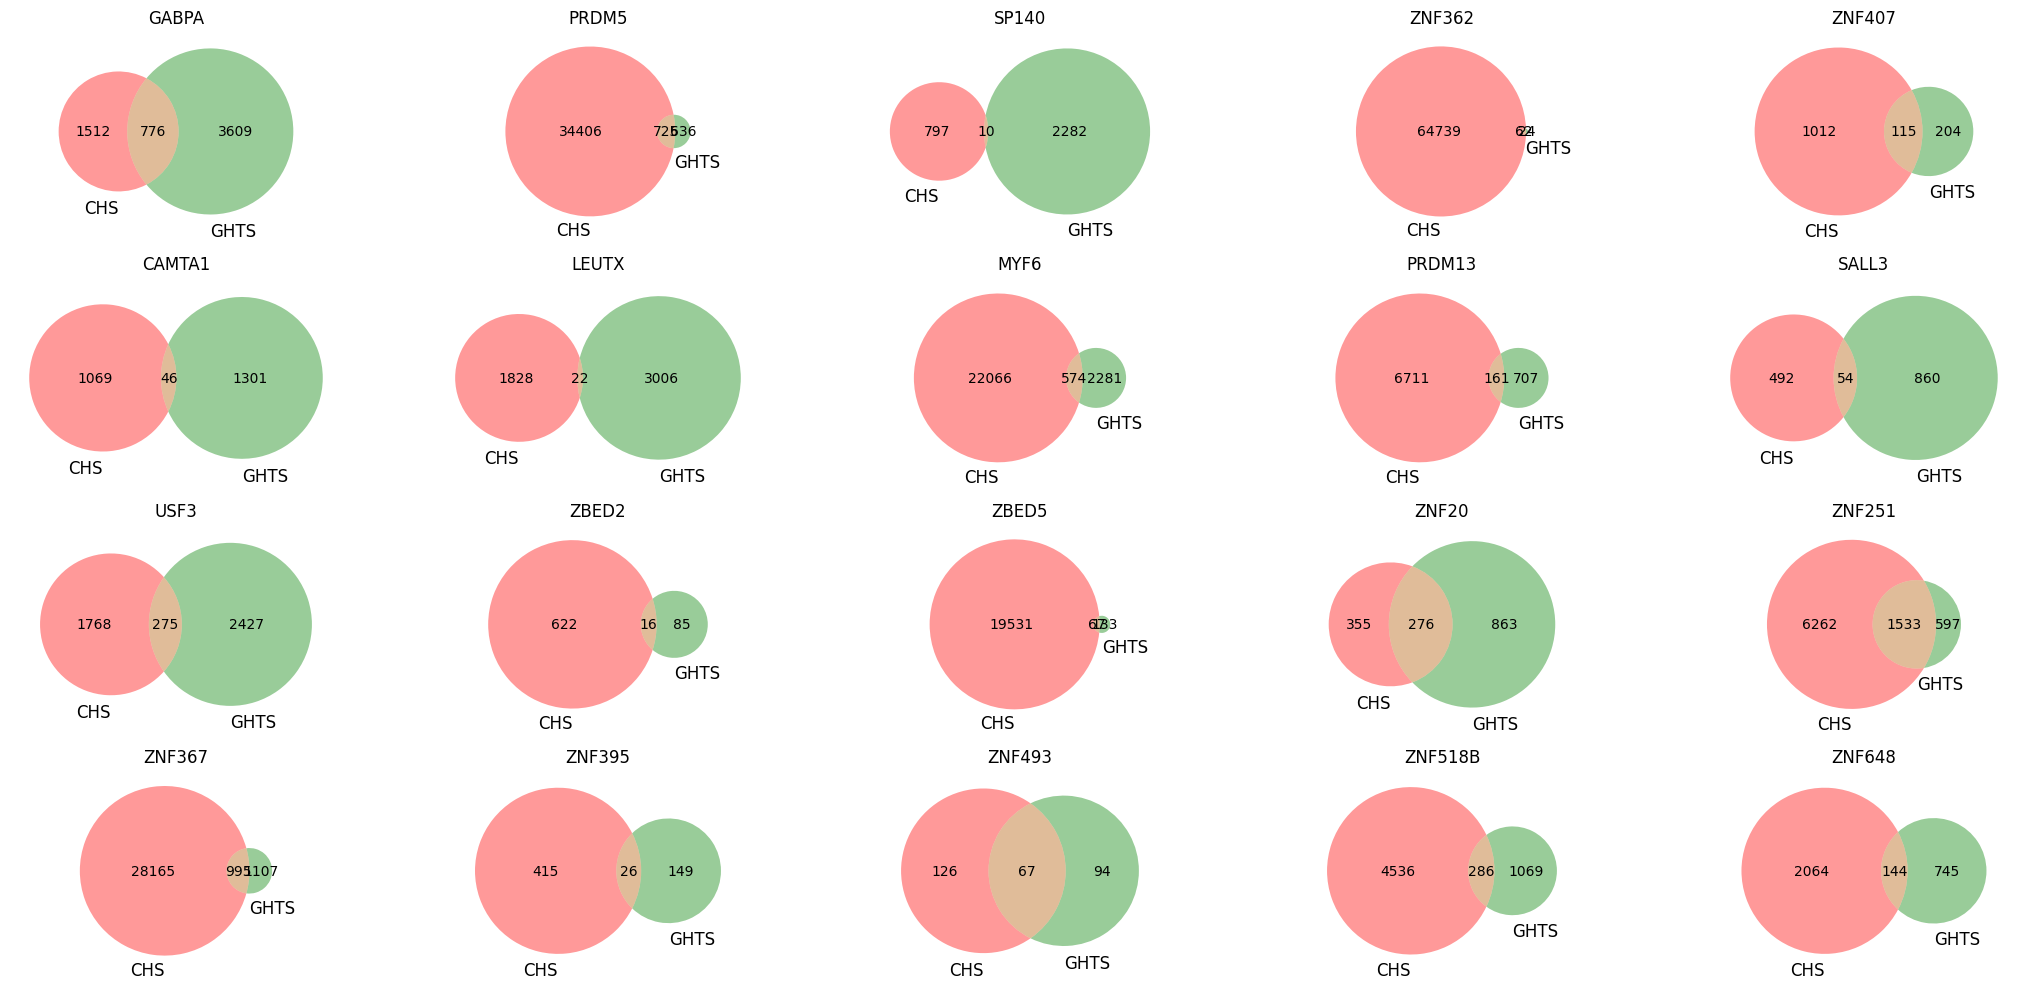

In [11]:
fig, axes = plt.subplots(4,5, figsize=(24,10), tight_layout=True)
L_TFs = ["GABPA", "PRDM5", "SP140", "ZNF362", "ZNF407"]
F_TFs = [_ for _ in os.listdir("/home/gregory.andrews-umw/IBIS/data/CHS/") if _ not in L_TFs]
TFs = L_TFs + F_TFs
assays = ["CHS", "GHTS"]
for i, tf in enumerate(TFs):
    chs_peaks = glob.glob("/home/gregory.andrews-umw/IBIS/data/CHS/{}/*".format(tf))
    ghts_peaks = glob.glob("/home/gregory.andrews-umw/IBIS/data/GHTS/{}/*".format(tf))
    cycles = sorted(list(set([os.path.basename(_).split(".")[-2] for _ in ghts_peaks])))
    max_cycle = cycles[-1]
    ghts_peaks = [_ for _ in ghts_peaks if max_cycle in _]
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        chs_bf = pd.concat([pd.read_csv(_, sep="\t", skiprows=1, skipfooter=1, usecols=[0,1,2], names=["chrom", "start", "end"], engine="python") for _ in chs_peaks]).sort_values(["chrom", "start"], ascending=[True, True]).reset_index(drop=True)
        ghts_bf = pd.concat([pd.read_csv(_, sep="\t", skiprows=1, skipfooter=1, usecols=[0,1,2], names=["chrom", "start", "end"], engine="python") for _ in ghts_peaks]).sort_values(["chrom", "start"], ascending=[True, True]).reset_index(drop=True)

    chs_bf = bioframe.merge(chs_bf)
    ghts_bf = bioframe.merge(ghts_bf)
    n_chs = chs_bf.shape[0]
    n_ghts = ghts_bf.shape[0]
    closest_df = bioframe.closest(chs_bf, ghts_bf)
    n_shared = closest_df[closest_df["distance"] == 0].shape[0]
    ax = axes.flatten()[i]
    v = venn2([n_chs - n_shared, n_ghts - n_shared, n_shared], set_labels = ('CHS', 'GHTS'), ax=ax)
    # v.get_label_by_id('10').set_position((-0.2, 0.2)) 
    # v.get_label_by_id('01').set_position((0.2, 0.2)) 
    # v.get_label_by_id('11').set_position((0, 0)) 
    ax.set_title(tf)
plt.savefig("CHS-GHTS-Venn.png")

In [12]:
L_TFs = ["LEF1", "NACC2", "NFKB1", "RORB", "TIGD3"]
F_TFs = [_ for _ in os.listdir("/home/gregory.andrews-umw/IBIS/data/HTS/") if _ not in L_TFs]
TFs = L_TFs + F_TFs

In [13]:
with open("IBIS-Metadata-Artificial.txt", "w") as f:
    for tf in TFs:
        if tf in L_TFs:
            phase = "L"
        else:
            phase = "F"
            
        for cycle in ["C1", "C2", "C3", "C4"]:
            hts_fastqs = glob.glob("/home/gregory.andrews-umw/IBIS/data/HTS/{}/*_{}_*gz".format(tf, cycle))
            n = len(hts_fastqs)
            if n > 0:
                n_seqs = 0
                for fastq in hts_fastqs:
                    with gzip.open(fastq) as fq:
                        for line in fq:
                            n_seqs += 1
                n_seqs = n_seqs // 4
                
                print(tf, "HTS-{}".format(cycle), phase, n, n_seqs, sep="\t", file=f)
            else:
                print(tf, "HTS-{}".format(cycle), "absent", n, 0, sep="\t", file=f)

        pbm_files = glob.glob("/home/gregory.andrews-umw/IBIS/data/PBM/{}/*".format(tf))
        if len(pbm_files) > 0:
            n_probes = 0
            with open(pbm_files[0]) as fq:
                for line in fq:
                    n_probes += 1
            
            print(tf, "PBM", phase, len(pbm_files), n_probes, sep="\t", file=f)
        else:
            print(tf, "PBM", "absent", len(pbm_files), 0, sep="\t", file=f)
            

        sms_fastqs = glob.glob("/home/gregory.andrews-umw/IBIS/data/SMS/{}/*".format(tf))
        if len(sms_fastqs) > 0:
            n_reads = 0
            for fastq in sms_fastqs:
                with gzip.open(fastq) as fq:
                    for line in fq:
                        n_reads += 1
            n_reads = n_reads // 4
            print(tf, "SMS", phase, len(sms_fastqs), n_reads, sep="\t", file=f)
        else:
            print(tf, "SMS", "absent", len(sms_fastqs), 0, sep="\t", file=f)

In [14]:
!cat IBIS-Metadata-Artificial.txt | grep NACC2

NACC2	HTS-C1	L	2	626194
NACC2	HTS-C2	L	2	911226
NACC2	HTS-C3	L	2	879511
NACC2	HTS-C4	L	1	642075
NACC2	PBM	L	2	40525
NACC2	SMS	L	1	48912
